In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
import pandas as pd

df = pd.read_csv("/kaggle/input/spam-email/spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:

df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [5]:
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [6]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 3)

In [7]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 3)

In [8]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 3)

In [9]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 3)

In [10]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [11]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
3290,spam,Camera - You are awarded a SiPix Digital Camer...,1
1112,ham,"Awesome, think we can get an 8th at usf some t...",0
3385,spam,FREE MSG:We billed your mobile number by mista...,1
2677,ham,* Am on a train back from northampton so i'm a...,0
3530,spam,Xmas & New Years Eve tickets are now on sale f...,1


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [13]:
X_train.head(10)


3885    A link to your picture has been sent. You can ...
2037    You can jot down things you want to remember l...
5419    I'm at bruce &amp; fowler now but I'm in my mo...
4060    Moby Pub Quiz.Win a £100 High Street prize if ...
2913    You didn't have to tell me that...now i'm thin...
5145    Aiyar u so poor thing... I give u my support k...
2597    No i'm not gonna be able to. || too late notic...
551     Imagine you finally get to sink into that bath...
135     Want 2 get laid tonight? Want real Dogging loc...
4967    URGENT! We are trying to contact U. Todays dra...
Name: Message, dtype: object

In [14]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [15]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [16]:

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)


In [17]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 291s 8s/step - loss: 0.6321 - accuracy: 0.6562 - precision: 0.6582 - recall: 0.6500
Epoch 2/10
35/35 [==============================] - 279s 8s/step - loss: 0.5074 - accuracy: 0.8170 - precision: 0.8024 - recall: 0.8411
Epoch 3/10
35/35 [==============================] - 278s 8s/step - loss: 0.4337 - accuracy: 0.8607 - precision: 0.8556 - recall: 0.8679
Epoch 4/10
35/35 [==============================] - 278s 8s/step - loss: 0.3838 - accuracy: 0.8848 - precision: 0.8748 - recall: 0.8982
Epoch 5/10
35/35 [==============================] - 278s 8s/step - loss: 0.3523 - accuracy: 0.8857 - precision: 0.8763 - recall: 0.8982
Epoch 6/10
35/35 [==============================] - 277s 8s/step - loss: 0.3293 - accuracy: 0.8938 - precision: 0.8973 - recall: 0.8893
Epoch 7/10
35/35 [==============================] - 280s 8s/step - loss: 0.3179 - accuracy: 0.9018 - precision: 0.8840 - recall: 0.9250
Epoch 8/10
35/35 [==============================

In [18]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 93s 8s/step - loss: 0.2911 - accuracy: 0.9144 - precision: 0.9189 - recall: 0.9091


[0.29105237126350403,
 0.9144384860992432,
 0.9189189076423645,
 0.9090909361839294]

In [19]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 93s 8s/step


In [20]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[172,  15],
       [ 17, 170]])

Text(50.722222222222214, 0.5, 'Truth')

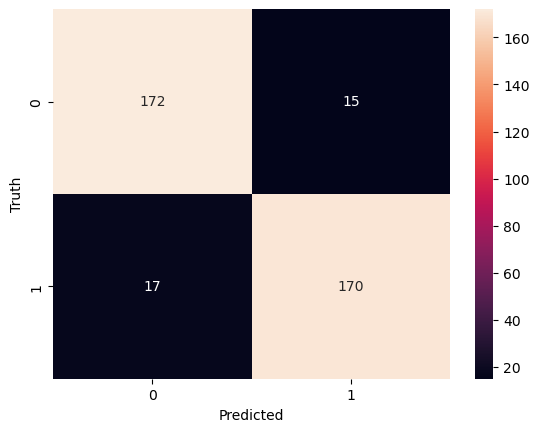

In [22]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [23]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       187
           1       0.92      0.91      0.91       187

    accuracy                           0.91       374
   macro avg       0.91      0.91      0.91       374
weighted avg       0.91      0.91      0.91       374

